# Time Series Feature Engineering

# 0. Initialize

In [26]:
import os; from importlib import reload;
from utils import constants 
from utils.constants import *
%cd {os.environ['PROJECT_PATH']}

import warnings
warnings.filterwarnings('ignore')

/app


# 1. Connect, Load & Preprocess Data

In [27]:
EXP_TYPE = 'HLV'

In [28]:
from data import load_data; reload(load_data)
from data import preprocess; reload(preprocess)

# dfBpAll, dfImuAll = load_data.load_dataframe_from_mat(folder='data/raw_mat/', pattern=f'{EXP_TYPE}')
# dfAll = preprocess.merge_imu_vcg_with_heartbeats(dfBpAll, dfImuAll)
dfAll = load_data.load_dataframe_from_pickle(folder='data/interim',pattern=EXP_TYPE)
dfAll

,file,ax,ay,az,gx,gy,gz,heartbeat,patient,test_type,test_num,tsCC,ts,pp,sbp,dbp,test_type_bp,test_num_bp,patient_bp
0,sub112_HLV1.mat,-1.122880,-0.571017,-9.860519,0.362396,3.185272,-0.434875,3.0,sub112,HLV,1,True,0 days 00:00:02.699000,56.675948,118.611859,61.935911,HLV,1,sub112
1,sub112_HLV1.mat,-1.137246,-0.603339,-9.835379,0.457764,3.463745,-0.640869,3.0,sub112,HLV,1,True,0 days 00:00:02.704000,56.675948,118.611859,61.935911,HLV,1,sub112
2,sub112_HLV1.mat,-1.096544,-0.555455,-9.897629,0.656128,3.807068,-0.511169,3.0,sub112,HLV,1,True,0 days 00:00:02.709000,56.675948,118.611859,61.935911,HLV,1,sub112
3,sub112_HLV1.mat,-1.104924,-0.611718,-9.907205,0.244141,3.414154,-0.507355,3.0,sub112,HLV,1,True,0 days 00:00:02.714000,56.675948,118.611859,61.935911,HLV,1,sub112
4,sub112_HLV1.mat,-1.096544,-0.575805,-9.947907,0.442505,3.047943,-0.320435,3.0,sub112,HLV,1,True,0 days 00:00:02.719000,56.675948,118.611859,61.935911,HLV,1,sub112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114048,sub251_HLV2.mat,-0.741005,0.271742,-10.023324,-0.537872,4.753113,0.209808,105.0,sub251,HLV,2,True,0 days 00:01:44.276000,23.849566,108.693039,84.843473,HLV,2,sub251
114049,sub251_HLV2.mat,-0.750582,0.262165,-10.075997,-0.541687,4.955292,0.080109,105.0,sub251,HLV,2,True,0 days 00:01:44.281000,23.849566,108.693039,84.843473,HLV,2,sub251
114050,sub251_HLV2.mat,-0.709881,0.286107,-10.044872,-0.457764,4.978180,0.349045,105.0,sub251,HLV,2,True,0 days 00:01:44.286000,23.849566,108.693039,84.843473,HLV,2,sub251
114051,sub251_HLV2.mat,-0.766144,0.246603,-10.046069,-0.392914,4.718781,-0.030518,105.0,sub251,HLV,2,True,0 days 00:01:44.291000,23.849566,108.693039,84.843473,HLV,2,sub251


# 2. Prep Train & Test Splits

In [34]:
from models import experiments

dfImu_raw = dfAll[constants.INDICIES + constants.IMU_COLS]
dfBp_raw = dfAll[constants.INDICIES + constants.BP_COLS]

dfImu = dfImu_raw.copy()
dfBp = dfBp_raw.copy()

dfVects = pd.read_feather(f"data/vectors/dfImuVects-{EXP_TYPE}.feather")
dfVects.file = dfVects.reset_index().file.str.extract(pat='/[0-9]+_CCs_(sub[0-9]+_\w+.mat)$')
dfVects = dfVects.set_index(INDICIES)

dfImu = dfImu[dfImu.file.isin(pd.Series(dfVects.reset_index().file.unique()).sort_values().to_list())]
dfBp = dfBp[dfBp.file.isin(pd.Series(dfVects.reset_index().file.unique()).sort_values().to_list())]

sampleRandTestInds = experiments.split_by_random(dfImu, dfBp)
sampleExpDfs = experiments.get_experiment(sampleRandTestInds[0], dfImu, dfBp)


# 3. Modeling Pipeline

In [35]:
import sklearn
from sklearn.pipeline import Pipeline

from features import tsfel_vectorizer; reload(tsfel_vectorizer)
from sklearn import feature_selection

# tsVectorLookupTransform = preprocess.FunctionTransformer(partial(features_simple.vectorize_mean_std))
tsVectorLookupTransform = sklearn.preprocessing.FunctionTransformer(tsfel_vectorizer.VectorLookup(dfVects))

pipe_vect_tsfel = Pipeline([
    ('transform', tsVectorLookupTransform), 
    ('feature_selection_simple', feature_selection.VarianceThreshold()),
    ('feature_selection', feature_selection.SelectFromModel(sklearn.linear_model.LinearRegression())),
    ('model', sklearn.ensemble.GradientBoostingRegressor())])

# 4. Run Pipelines

In [36]:
from sklearn.metrics import mean_absolute_error



for pipe in [pipe_vect_tsfel]:
    pipe.fit(sampleExpDfs['train_x'], sampleExpDfs['train_y'].groupby(constants.INDICIES)['sbp'].mean())
    score = mean_absolute_error(
        pipe.predict(sampleExpDfs['test_x']),
        sampleExpDfs['test_y'].groupby(constants.INDICIES)['sbp'].mean()
    )
    print('Achieved Score (MAE) : ', score, pipe)

output_series.shape (509, 2310) 0       365
2310    144
dtype: int64
output_series.shape (128, 2310) 0       93
2310    35
dtype: int64
Achieved Score (MAE) :  5.5132624458357835 Pipeline(steps=[('transform',
                 FunctionTransformer(func=<function VectorLookup.<locals>.vectLookup at 0x7f3849c1e430>)),
                ('feature_selection_simple', VarianceThreshold()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearRegression())),
                ('model', GradientBoostingRegressor())])


---- Random Forest Model ----
PipelineDebug:: (91067, 10)
output_series.shape (509, 2310) 0       365
2310    144
dtype: int64
PipelineDebug:: (509, 2310)
PipelineDebug:: (509, 30)
PipelineDebug:: (22986, 10)
output_series.shape (128, 2310) 0       93
2310    35
dtype: int64
PipelineDebug:: (128, 2310)
PipelineDebug:: (128, 30)
mean_absolute_error, r2_score :  2.697 0.845
PipelineDebug:: (91424, 10)
output_series.shape (509, 2310) 0       362
2310    147
dtype: int64
PipelineDebug:: (509, 2310)
PipelineDebug:: (509, 30)
PipelineDebug:: (22629, 10)
output_series.shape (128, 2310) 0       96
2310    32
dtype: int64
PipelineDebug:: (128, 2310)
PipelineDebug:: (128, 30)
mean_absolute_error, r2_score :  2.901 0.76
PipelineDebug:: (91380, 10)
output_series.shape (509, 2310) 0       381
2310    128
dtype: int64
PipelineDebug:: (509, 2310)
PipelineDebug:: (509, 30)
PipelineDebug:: (22673, 10)
output_series.shape (128, 2310) 0       77
2310    51
dtype: int64
PipelineDebug:: (128, 2310)
Pipelin

<AxesSubplot:title={'center':'Random Forest Model'}, xlabel='dbp', ylabel='preds'>

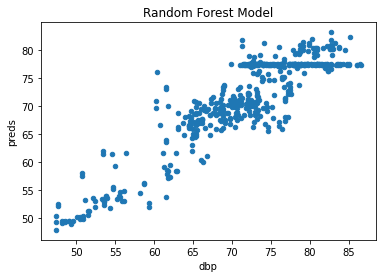

In [37]:
from models import baselines, experiments;
reload(baselines); reload(tsfel_vectorizer);

serSelectedColumns = dfVects.columns[:30].values
vectFeatureSelection = tsfel_vectorizer.transform_selectFeatures(serSelectedColumns)
# vectFeatureSelection = FunctionTransformer(partial(selectFeatures, features=serTopFeatures.head(50).index))
# vectFeatureSelection = sklearn.preprocessing.FunctionTransformer(partial(selectFeatures, features=serSelectedColumns))


print('---- Random Forest Model ----')
pipeVectRF = Pipeline([
    ('debug1',baselines.Debug()), ('scaler', tsVectorLookupTransform), 
    ('debug2', baselines.Debug()), ('select_features',vectFeatureSelection), 
    ('normalize_features',sklearn.preprocessing.StandardScaler()), 
    ('debug3',baselines.Debug()), ('model', sklearn.ensemble.RandomForestRegressor())
])

rfResults = experiments.testPipeline(dfImu, dfBp, pipeVectRF, sampleRandTestInds, targetCol='dbp', verbose=True)

experiments.resultsToDf(rfResults).plot.scatter('dbp','preds', title='Random Forest Model')

# Manual Scripts & Batch

In [9]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined

## 1. Build Features

In [ ]:
dfVectors = tsfel_vectorizer.vectorize_tsfel(dfAll)
dfVectors

In [ ]:
dfVectors.reset_index().to_feather("data/vectors/dfImuVects-"+"LLV"+".feather")

## 2. Review Features Importances

In [ ]:
arrDfFeatImps = [
 pd.read_csv("data/feature_importances/output_feat_imp_"+expType+'.csv', index_col=0).assign(exp=expType)
 for expType in ['LLV','HLV','bre','res'] 
]
dfFeatImps = pd.concat(arrDfFeatImps).sort_values('feat_imp', ascending=False)

# Rename Columns
replFnc = lambda a : str(dfImu.columns.get_loc(a.group(0)))
dfFeatImps['feat_name'] = dfFeatImps['feat_name'].str.replace(pat='^(\w{2})', repl=replFnc)
# dfFeatImps['feat_name'].str.replace(pat='^\w\w', repl=replFnc)
dfFeatImps

In [ ]:
from models import baselines
reload(tsfel_vectorizer)
from sklearn.base import TransformerMixin, BaseEstimator

class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        print(X.shape)
        self.shape = X.shape
        self.head = X.head()
        # what other output you want
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:

arrTopFeatures = dfFeatImps.head(50).feat_name
sampleRandTestInds = experiments.split_by_random(dfImu, dfBp)

tsfelVectTransform = tsfel_vectorizer.transform_vectorLookup(dfVects)
vectSelectTransform = tsfel_vectorizer.transform_selectFeatures(arrTopFeatures)

print('---- Random Forest Model ----')
pipeVectRF = Pipeline([('debug1',Debug()), ('scaler', tsfelVectTransform), ('debug2',Debug()), ('select_features',vectSelectTransform), ('debug3',Debug()), ('model', sklearn.ensemble.RandomForestRegressor())])
# pipeVectRF = Pipeline([
#     ('scaler', tsfelVectTransform), 
#     ('select_features', vectSelectTransform), 
#     # ('select_features',tsfel_vectorizer.transform_selectFeatures(arrTopFeatures)), 
#     ('model', sklearn.ensemble.RandomForestRegressor()),
#     # ('model', baselines.RandomRegressor())
    
# ])
# rfResults = experiments.testPipeline(dfImu, dfBp, pipeVectRF, sampleRandTestInds, targetCol='dbp', verbose=True)
rfResults = experiments.testPipeline(dfImu, dfBp, pipe_vect_tsfel, sampleRandTestInds, targetCol='dbp', verbose=True)

experiments.resultsToDf(rfResults).plot.scatter('dbp','preds', title='Random Forest Model')

In [ ]:
pipeVectRF.steps[4][1].head